In [1]:
import torch
from torchvision import transforms
from matplotlib import pyplot as plt
from torchinfo import summary

from networks_medium import Encoder, Decoder
from Autoencoders import ConformalAutoencoder
from data import CelebA

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

/home/dgalperi/anaconda3/envs/max/lib/python3.13/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


device(type='cuda', index=1)

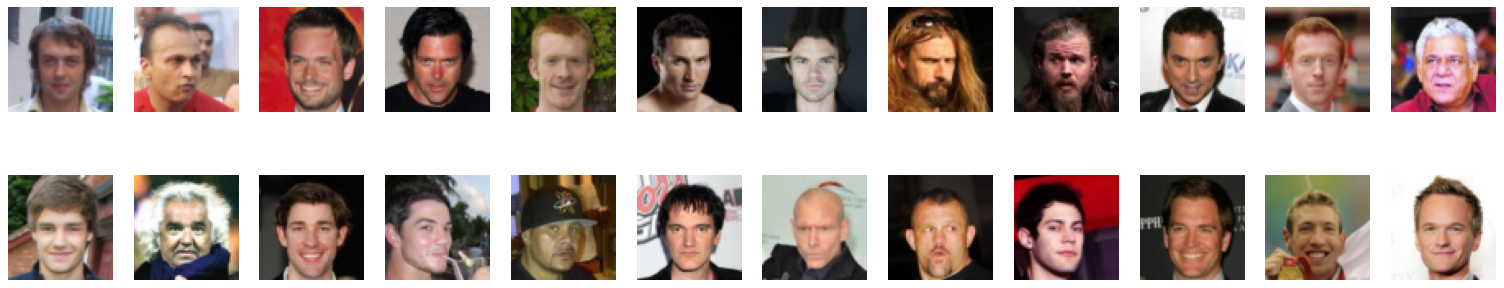

In [2]:
transform = [transforms.CenterCrop((178, 178)), transforms.Resize((64, 64))]
train_dataset = CelebA(root_dir="../", split="train", transform=transform, device=device, filter_categories=[(15, False), (20, True)])
val_dataset = CelebA(root_dir="../", split="val", transform=transform, device=device, filter_categories=[(15, False), (20, True)])

# show 2 rows of 12 images from train dataset
plt.figure(figsize=(24, 5), dpi=80)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(train_dataset[i][0].cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [3]:
z_dim = 1024
in_ch = 3
out_ch = 3
base_ch = 32 #64
gap_ch = 3

encoder = Encoder(z_dim=z_dim, in_ch=in_ch, base_ch=base_ch, gap_ch=gap_ch)
decoder = Decoder(z_dim=z_dim, out_ch=out_ch, base_ch=base_ch, gap_ch=gap_ch)
encoder._build_fc_if_needed(16, 16)
decoder._build_fc_if_needed(16, 16)

In [4]:
summary(encoder, input_size=(1, in_ch, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 1024]                 --
├─ConvBNReLU: 1-1                        [1, 32, 64, 64]           --
│    └─Sequential: 2-1                   [1, 32, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 32, 64, 64]           864
│    │    └─BatchNorm2d: 3-2             [1, 32, 64, 64]           64
│    │    └─ReLU: 3-3                    [1, 32, 64, 64]           --
├─ConvBNReLU: 1-2                        [1, 64, 32, 32]           --
│    └─Sequential: 2-2                   [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-4                  [1, 64, 32, 32]           18,432
│    │    └─BatchNorm2d: 3-5             [1, 64, 32, 32]           128
│    │    └─ReLU: 3-6                    [1, 64, 32, 32]           --
├─ConvBNReLU: 1-3                        [1, 64, 32, 32]           --
│    └─Sequential: 2-3                   [1, 64, 32, 32]           --
│    │   

In [5]:
from metrics import conformality_cosine_loss, conformality_trace_loss

lambda_conf = 0.0
lambda_reg = 0.0
lambda_aug = 0.0

conformal_autoencoder = ConformalAutoencoder(encoder, decoder, lambda_conf=lambda_conf, lambda_reg=lambda_reg, reg_in_loss=True, lambda_aug=lambda_aug).to(device)
# conformal_autoencoder.conformality_loss = conformality_cosine_loss  #-14GB

In [6]:
bs = 256
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False)

In [7]:
conformal_autoencoder.load_model_from_checkpoint("models/celeba_conformal_autoencoder_v1_2.pth")

Model and custom variables loaded from models/celeba_conformal_autoencoder_v1_2.pth


ConformalAutoencoder(
  (encoder): Encoder(
    (conv0): ConvBNReLU(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (down1): ConvBNReLU(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (conv1): ConvBNReLU(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (down2): ConvBNReLU(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2,

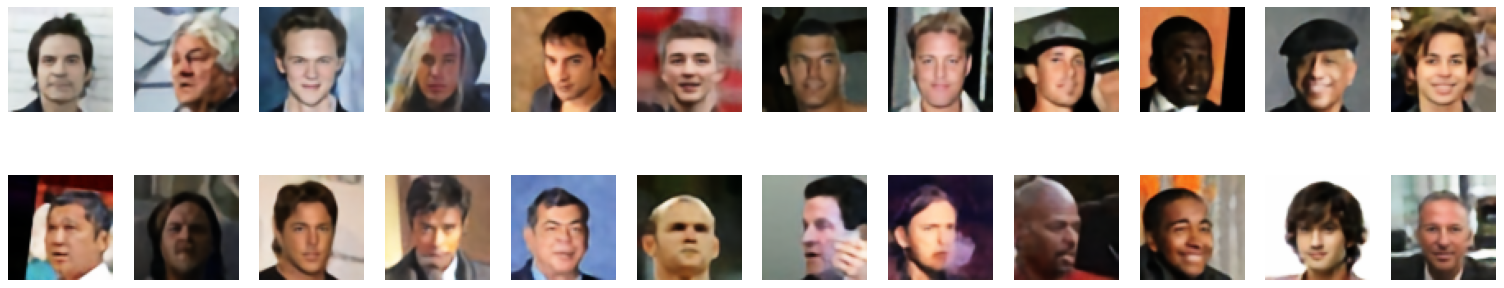

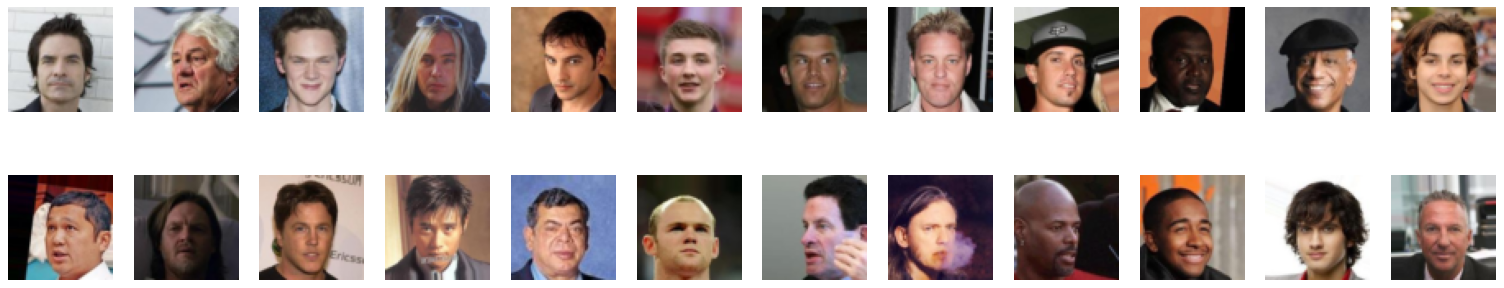

In [10]:
samples = conformal_autoencoder.forward(val_dataset.get_sample(24, seed=32)[0].to(device))
plt.figure(figsize=(24, 5), dpi=80)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(samples[i].permute(1, 2, 0).detach().cpu())
    plt.axis('off')
plt.show()
plt.figure(figsize=(24, 5), dpi=80)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(val_dataset.get_sample(24, seed=32)[0][i].permute(1, 2, 0).detach().cpu())
    plt.axis('off')
plt.show()

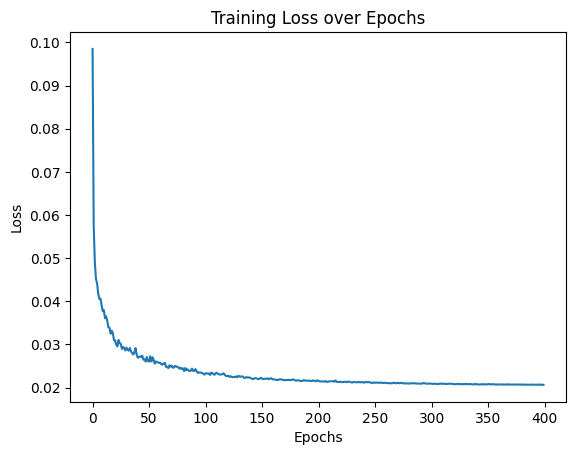

In [11]:
plt.plot(conformal_autoencoder.metrics_list["reconstruction_loss"][:], label="Reconstruction Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

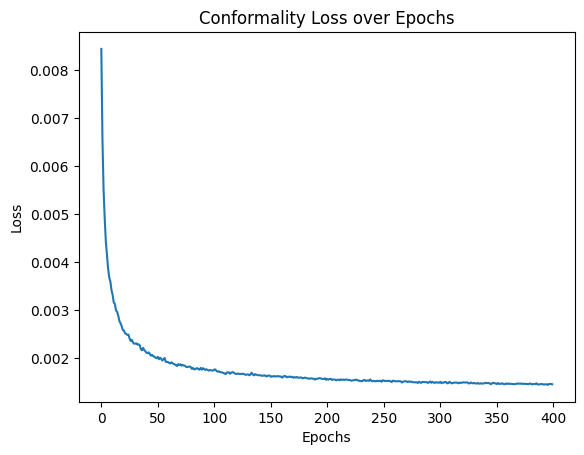

In [12]:
plt.plot(conformal_autoencoder.metrics_list["conformal_loss"][:], label="Conformal Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Conformality Loss over Epochs")
plt.show()

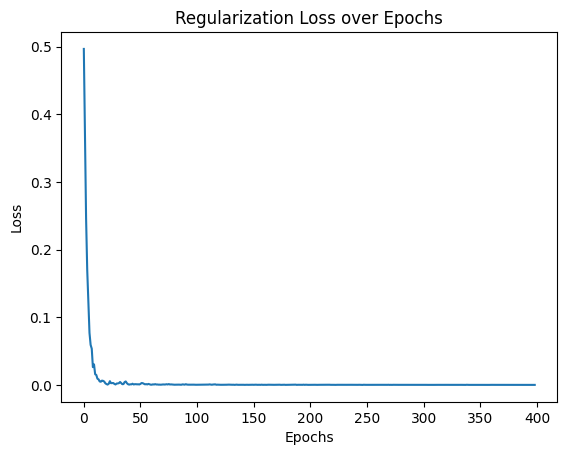

In [14]:
plt.plot(conformal_autoencoder.metrics_list["regularization_loss"][1:], label="Regularization Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Regularization Loss over Epochs")
plt.show()

In [16]:
test_data = val_dataset.get_sample(100, seed=42)[0]
latent = conformal_autoencoder.encoder(test_data.to(device))
latent.shape

torch.Size([100, 1024])

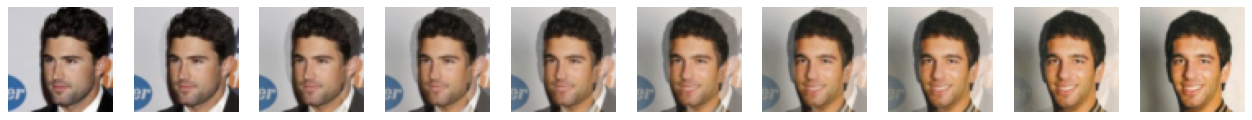

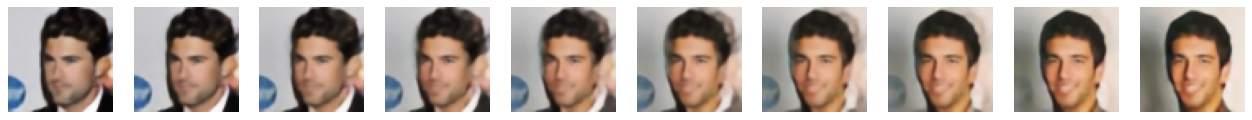

In [40]:
index_1 = 25
index_2 = 26
steps = 10

interpolated = []
for alpha in torch.linspace(0, 1, steps):
    interpol= (1 - alpha) * test_data[index_1] + alpha * test_data[index_2]
    interpolated.append(interpol.unsqueeze(0))
interpolated = torch.cat(interpolated, dim=0)

plt.figure(figsize=(24, 5), dpi=80)
for i in range(steps):
    plt.subplot(2, 12, i + 1)
    plt.imshow(interpolated[i].permute(1, 2, 0).detach().cpu())
    plt.axis('off')
plt.show()

interpolated_recon = []
latent1, latent2 = latent[[index_1, index_2]]
for alpha in torch.linspace(0, 1, steps):
    interpol_latent = (1 - alpha) * latent1 + alpha * latent2
    recon = conformal_autoencoder.decoder(interpol_latent.unsqueeze(0))
    interpolated_recon.append(recon.unsqueeze(0))
interpolated_recon = torch.cat(interpolated_recon, dim=0)

plt.figure(figsize=(24, 5), dpi=80)
for i in range(steps):
    plt.subplot(2, 12, i + 1)
    plt.imshow(interpolated_recon[i][0].permute(1, 2, 0).detach().cpu())
    plt.axis('off')
plt.show()

In [7]:
conformal_autoencoder.load_model_from_checkpoint("models/celeba_autoencoder_v1_2.pth")

Model and custom variables loaded from models/celeba_autoencoder_v1_2.pth


ConformalAutoencoder(
  (encoder): Encoder(
    (conv0): ConvBNReLU(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (down1): ConvBNReLU(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (conv1): ConvBNReLU(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (down2): ConvBNReLU(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2,

In [9]:
test_data = val_dataset.get_sample(100, seed=42)[0]
latent = conformal_autoencoder.encoder(test_data.to(device))
latent.shape

torch.Size([100, 1024])

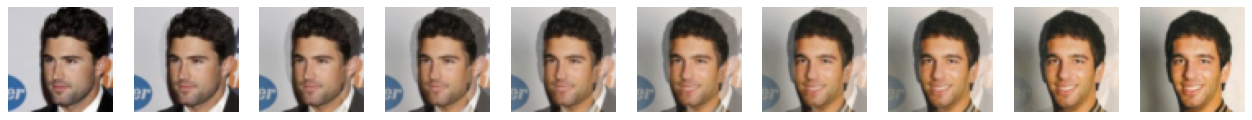

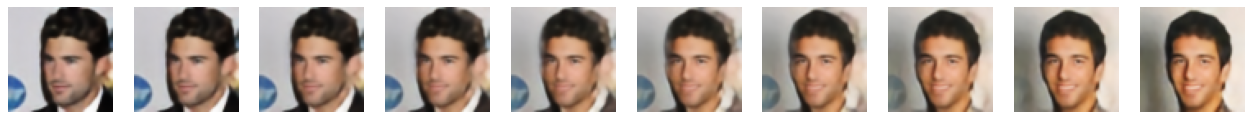

In [10]:
index_1 = 25
index_2 = 26
steps = 10

interpolated = []
for alpha in torch.linspace(0, 1, steps):
    interpol= (1 - alpha) * test_data[index_1] + alpha * test_data[index_2]
    interpolated.append(interpol.unsqueeze(0))
interpolated = torch.cat(interpolated, dim=0)

plt.figure(figsize=(24, 5), dpi=80)
for i in range(steps):
    plt.subplot(2, 12, i + 1)
    plt.imshow(interpolated[i].permute(1, 2, 0).detach().cpu())
    plt.axis('off')
plt.show()

interpolated_recon = []
latent1, latent2 = latent[[index_1, index_2]]
for alpha in torch.linspace(0, 1, steps):
    interpol_latent = (1 - alpha) * latent1 + alpha * latent2
    recon = conformal_autoencoder.decoder(interpol_latent.unsqueeze(0))
    interpolated_recon.append(recon.unsqueeze(0))
interpolated_recon = torch.cat(interpolated_recon, dim=0)

plt.figure(figsize=(24, 5), dpi=80)
for i in range(steps):
    plt.subplot(2, 12, i + 1)
    plt.imshow(interpolated_recon[i][0].permute(1, 2, 0).detach().cpu())
    plt.axis('off')
plt.show()

torch.Size([10, 1, 3, 64, 64])


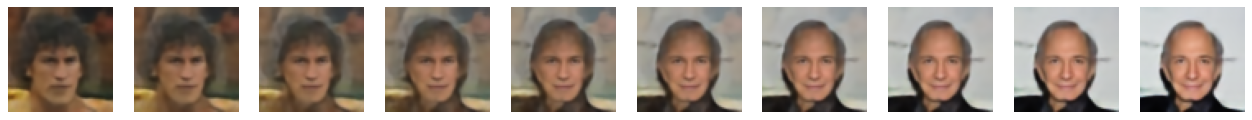

In [ ]:

index_1 = 0
index_2 = 1
steps = 10
interpolated_recon = []
latent1, latent2 = latent[[index_1, index_2]]
for alpha in torch.linspace(0, 1, steps):
    interpol_latent = (1 - alpha) * latent1 + alpha * latent2
    recon = conformal_autoencoder.decoder(interpol_latent.unsqueeze(0))
    interpolated_recon.append(recon.unsqueeze(0))
interpolated_recon = torch.cat(interpolated_recon, dim=0)

plt.figure(figsize=(24, 5), dpi=80)
for i in range(steps):
    plt.subplot(2, 12, i + 1)
    plt.imshow(interpolated_recon[i][0].permute(1, 2, 0).detach().cpu())
    plt.axis('off')
plt.show()

In [ ]:
from metrics_copy import evaluate_conformality

evaluate_conformality(conformal_autoencoder, val_dataset.get_sample(50, seed=42)[0].to(device), chunk_size=64)

In [15]:
latent = conformal_autoencoder.encoder(val_dataset.get_sample(1, seed=42)[0].to(device))
latent.shape

torch.Size([1, 512])

In [16]:
def compute_full_jacobian_per_sample(func, z, device=None):
    """
    Compute full Jacobian for each sample sequentially (low peak memory).
    Returns a list of jacobians (tensor per sample) or writes them to disk.
    Warning: each jacobian is large (O(output_dim * latent_dim)).
    """
    jacobians = []
    for i in range(z.size(0)):
        zi = z[i:i+1]  # (1, L)
        # compute jacobian of flattened outputs wrt input vector zi
        def single_out(x):
            return func(x).view(-1)   # returns (out_dim,)
        Ji = torch.autograd.functional.jacobian(single_out, zi, create_graph=False)  # shape (out_dim, 1, L) maybe
        Ji = Ji.view(-1, zi.size(1))  # (out_dim, L)
        jacobians.append(Ji)
        # optionally torch.save(Ji.cpu(), f'jac_{i}.pt') and del Ji to free memory
    return jacobians

In [17]:
from metrics import get_batch_jacobian
jacobians = compute_full_jacobian_per_sample(conformal_autoencoder.decoder, latent)

In [18]:
jacobians = torch.stack(jacobians)  # (B, out_dim, z_dim)

In [19]:
jacobians.shape

torch.Size([1, 12288, 512])

In [20]:
JtJs = torch.einsum('bji,bjk->bik', jacobians, jacobians)
JtJs

tensor([[[ 1.3424e+00,  2.8221e-02, -5.6820e-02,  ...,  6.1263e-02,
          -1.4514e-01,  6.1126e-03],
         [ 2.8221e-02,  6.1792e-01, -4.4574e-02,  ..., -1.6516e-03,
          -4.4778e-02,  6.2035e-02],
         [-5.6820e-02, -4.4574e-02,  8.8809e-01,  ...,  2.9897e-02,
          -2.6389e-02,  4.7067e-04],
         ...,
         [ 6.1263e-02, -1.6516e-03,  2.9897e-02,  ...,  1.8236e+00,
          -1.2986e-01, -4.0034e-02],
         [-1.4514e-01, -4.4778e-02, -2.6389e-02,  ..., -1.2986e-01,
           8.6048e-01,  4.0069e-02],
         [ 6.1126e-03,  6.2035e-02,  4.7067e-04,  ..., -4.0034e-02,
           4.0069e-02,  9.9141e-01]]], device='cuda:1')

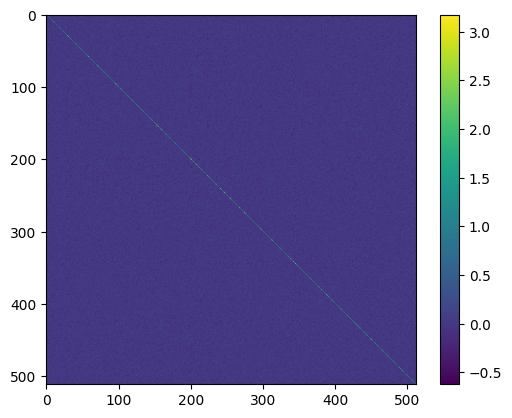

In [22]:
plt.imshow(JtJs[0].cpu().detach())
plt.colorbar()
plt.show()

In [20]:
print(JtJs[0].diagonal().max())
print(JtJs[0].diagonal().min())
print(JtJs[0].diagonal().mean())
print(torch.std(JtJs[0].diagonal(), dim=0))

tensor(0.1395, device='cuda:1')
tensor(0.0801, device='cuda:1')
tensor(0.1063, device='cuda:1')
tensor(0.0097, device='cuda:1')


In [21]:
from torch import vmap
trace = vmap(torch.trace)(JtJs)
print(trace)
conf_factor = trace / latent.size(1)
print(conf_factor)

tensor([54.4265], device='cuda:1')
tensor([0.1063], device='cuda:1')


In [22]:
torch.norm(JtJs)

tensor(3.4837, device='cuda:1')

In [23]:
eye = torch.eye(JtJs.shape[1], device=JtJs.device).repeat(JtJs.shape[0], 1, 1)
jTj_minus_lambdaI = JtJs - conf_factor.unsqueeze(1).unsqueeze(2).repeat(1, JtJs.shape[1], JtJs.shape[1]) * eye
# torch.norm(JtJs - torch.eye(JtJs.size(1), device=jacobians.device) * conf_factor, dim=(1,2)).mean(dim=1)
torch.norm(jTj_minus_lambdaI, dim=(1,2))

tensor([2.5200], device='cuda:1')

In [24]:
torch.norm(conf_factor.unsqueeze(1).unsqueeze(2).repeat(1, JtJs.shape[1], JtJs.shape[1]) * eye, dim=(1,2))

tensor([2.4053], device='cuda:1')

In [25]:
conf_factor = conf_factor.double()

In [26]:
1/2 * 512 * torch.log(conf_factor)

tensor([-573.8172], device='cuda:1', dtype=torch.float64)

In [27]:
conf_factor ** (512 /2)

tensor([6.2279e-250], device='cuda:1', dtype=torch.float64)

In [28]:
JtJs = JtJs.double()

In [29]:
log_det = 1/2*torch.logdet(JtJs)
log_det

tensor([-774.6341], device='cuda:1', dtype=torch.float64)

In [30]:
det = torch.det(JtJs)
det

tensor([0.], device='cuda:1', dtype=torch.float64)

In [31]:
from metrics import gini
gini_values = gini(torch.diagonal(JtJs, dim1=1, dim2=2))
gini_values

tensor(0.0514, device='cuda:1', dtype=torch.float64)

In [32]:
JtJs.max()

tensor(0.1395, device='cuda:1', dtype=torch.float64)

In [14]:
from metrics_copy import evaluate_conformality

evaluate_conformality(conformal_autoencoder, val_dataset.get_sample(50, seed=42)[0].to(device), chunk_size=64)

tensor([0., 0., 0., 0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:1', dtype=torch.float64)
tensor([3.8983e+09, 1.6848e-14, 1.1901e-16, 8.5305e-16, 2.4062e-71, 1.7627e+36,
        6.2325e-22, 2.0104e-04, 5.7460e+06, 7.7012e+03, 1.7028e-33, 2.5744e+15,
        2.8677e-01, 2.6324e+17, 2.1321e-08, 5.2539e+19, 1.0243e-13, 5.8453e+07,
        6.8715e-67, 3.3338e-56, 2.9614e+00, 7.3370e+00, 3.2731e-19, 8.2003e+26,
        9.7237e-22, 5.2022e+02, 3.4937e+13, 5.6833e-01, 5.5675e+21, 2.4521e-13,
        4.6390e-07, 8.0119e+23, 3.4540e+23, 4.8854e+16, 1.2658e+02, 8.3087e-61,
        8.3722e-51, 1.0961e-41, 6.9360e-02, 2.7669e-30, 1.1654e-07, 3.4580e-34,
        5.9092e-42, 2.3681e+16, 5.7943e+22, 3.3953e-06, 3.0617e+22, 5.0550e-12,
        1.7340e-05, 3.0878e+25], device='cuda:1', dtype=torch.float64)
tensor([1.9463e+09, 5.90

{'Reconstruction Error': 0.0027419368270784616,
 'Diagonal Uniformity (gini)': 0.2775949537754059,
 'Conformal Factor Mean': 0.9673705697059631,
 'Conformal Factor Std': 0.20777752995491028,
 'Conformal Factor Std (normalized)': 0.2147858738899231,
 'Conformal Factor Estimate Error': 0.024722985923290253,
 'Conformal Factor Estimate Error (normalized)': 0.025556890293955803,
 'Off-diagonal Mean': 0.059911251068115234,
 'Off-diagonal Mean (normalized)': 0.06337516754865646,
 'Off-diagonal Norm': 40.360904693603516,
 'Off-diagonal Norm (normalized)': 42.71255874633789,
 'Conformality Mean': 0.06072147563099861,
 'Conformality Mean (normalized)': 0.064211405813694,
 'Conformality Norm': 42.00910949707031,
 'Conformality Norm (normalized)': 44.381591796875,
 'Determinant Estimation Error': 3.5254035202061336e+34,
 'Determinant Estimation Error (normalized)': 2.9573228172829334e+41,
 'Determinant Estimation from Estimate Error': 2.4680781855989138e+31,
 'Determinant Estimation from Estimate

In [35]:
import torch
from torch import nn
from torch.func import jacrev, vmap  # in older versions: from functorch import jacrev, vmap

sample = val_dataset.get_sample(50, seed=42)[0].to(device)
latent = conformal_autoencoder.encoder(sample)

def f_single(x_single):
    # x_single: [D]
    # return [K]
    return conformal_autoencoder.decoder(x_single.unsqueeze(0)).squeeze(0).flatten()

# per-sample jacobian function: [D] -> [K, D]
with torch.no_grad():
    jacobian_single = jacrev(f_single, chunk_size=32)

    # vectorize over batch: [B, D] -> [B, K, D]
    batched_jacobian = vmap(jacobian_single)

    J = batched_jacobian(latent)  # [B, K, D]

In [58]:
J.shape

torch.Size([10, 12288, 512])

In [15]:
torch.cuda.empty_cache()

In [50]:
torch.autograd.functional.jacobian(f_single, latent[0:1])  # [1, K, D]

tensor([[[[[-3.3487e-05, -2.3836e-03,  2.8502e-03,  ..., -3.0934e-03,
            -1.6059e-03, -2.3981e-03]],

          [[-3.7149e-04, -2.7658e-03,  2.7835e-03,  ..., -4.3726e-03,
            -5.3781e-04, -3.1834e-03]],

          [[-1.2944e-03, -3.8885e-03,  2.3469e-03,  ..., -6.9693e-03,
             4.7651e-04, -4.6348e-03]],

          ...,

          [[ 5.3920e-03,  2.0713e-03,  2.3154e-03,  ...,  3.3730e-03,
            -4.8494e-03, -4.1200e-03]],

          [[ 5.7028e-03,  2.6152e-03,  1.7610e-03,  ...,  2.8765e-03,
            -3.4632e-03, -3.2667e-03]],

          [[ 6.0380e-03,  2.8394e-03,  1.3419e-03,  ...,  2.4259e-03,
            -2.5727e-03, -2.4299e-03]]],


         [[[ 1.0208e-03, -2.5347e-03,  6.7013e-03,  ..., -2.3928e-03,
            -2.3160e-04, -2.6854e-03]],

          [[ 3.7422e-04, -3.9984e-03,  5.9932e-03,  ..., -3.5960e-03,
             1.0541e-03, -3.0144e-03]],

          [[-1.1814e-03, -4.3712e-03,  4.9154e-03,  ..., -5.1293e-03,
             2.3449e-03,